In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
import json
from datetime import datetime, date
import os
import shapefile
from datetime import datetime as dt
from sentinelhub import CRS, BBox, DataCollection, SentinelHubCatalog, SHConfig
from sentinelhub.aws import AwsDownloadClient


from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import yaml
# open shape files for Cameroon
import geopandas as gpd


warnings.filterwarnings('ignore')

/Users/noeliaotero/opt/anaconda3/envs/pyRem/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Open file for credentials
PATH = '/Users/noeliaotero/Documents/Geo_analysis/'
# Read YAML file
with open(PATH + "credentials.yml", 'r') as stream:
    credentials_conf = yaml.safe_load(stream)
with open(PATH + "config_sentinel.yml", 'r') as stream:
    s_conf = yaml.safe_load(stream)


In [3]:

shafile_file = "/Users/noeliaotero/Documents/Geo_analysis/cmr/cmr.shp"
sh_cmr = gpd.read_file("/Users/noeliaotero/Documents/Geo_analysis/cmr/cmr.shp")

In [4]:
#geojson_data = shapefile.Reader(shafile_file).__geo_interface__

<AxesSubplot: >

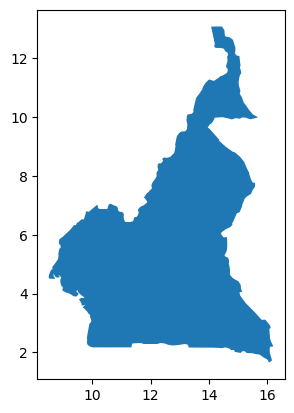

In [5]:
sh_cmr.plot()

In [6]:


# connect to the API
api = SentinelAPI(credentials_conf['user'], credentials_conf['password'], 'https://apihub.copernicus.eu/apihub')

In [7]:
footprint = geojson_to_wkt(read_geojson(s_conf['footprint_file']))

In [15]:
products = api.query(footprint,
                     date = (date(2020,1,1),date(2020,1,10)),
                     platformname = s_conf['platformname'],
                     processinglevel = s_conf['processinglevel'],
                     cloudcoverpercentage = (0, 20))
# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
images_df = api.to_geodataframe(products)

# GeoJSON FeatureCollection containing footprints and metadata of the scenes
# api.to_geojson(products)

In [16]:
if (len(images_df)>1):
    print(f"Number of products available: {len(images_df)}")
    print(f"Downloading product: {images_df.head(s_conf['download_index'])['title']}")

    # Select and download product to data directory.
    images_df = images_df.head(s_conf['download_index'])  # Get desired product based on selected index.
    cwd = os.getcwd()  # remember current work directory (CWD).
    os.chdir(s_conf['data_dir'])  # Change directory.
    api.download_all(products)
    #api.download_all(images_df.index)  # Download product. Needs '.index' as it cannot download df directly.
    os.chdir(cwd)  # Return to project directory.


Number of products available: 2
Name: title, dtype: object









































































































































































LTA retrieval: 100%|██████████| 1/1 [02:01<00:00, 121.46s/product]oduct]


In [41]:
# Unzip the files downloaded
from utils import * 
unzip(s_conf) 


In [40]:
# Now the tiff files must be created 
# https://medium.com/analytics-vidhya/two-ways-of-extracting-points-of-interest-from-sentinel-2a-data-baa124b1ed92

In [43]:
bands = ["B02", "B03", "B04", "B08", "B8A", "B11", "B12"]
resolutions = ["R10m", "R10m", "R10m", "R10m", "R20m", "R20m", "R20m"]
bands_and_resolutions = list(zip(bands, resolutions))

target_dim = (516, 516) # reduce dim.

In [37]:
data_dirs = []
for x in os.listdir(s_conf['data_dir']):
    if x.endswith('SAFE'):
        print(x)
        date = x.split("_")[2].split("T")[0]
        src_data_dir = glob.glob(os.path.join(s_conf['data_dir'], x, "GRANULE/*/IMG_DATA"))[0]
        data_dirs.append((date, src_data_dir))

data_dirs = sorted(data_dirs, key=lambda x: x[0])
    

S2A_MSIL2A_20200104T092401_N0213_R093_T32NRL_20200104T112307.SAFE
S2A_MSIL2A_20200107T093351_N0213_R136_T32NRL_20200107T112123.SAFE


In [42]:
tiff_root_data_dir = '/Users/noeliaotero/Documents/Geo_analysis/data/tiff/'
os.mkdir(tiff_root_data_dir)

In [56]:
# Need to check (not working properly now)
for date, src_data_dir in data_dirs:
    tiff_file = os.path.join(tiff_root_data_dir, date + ".tiff")
    
    if os.path.exists(tiff_file):
      
        continue
    
    tiff_file = None
    
    for i, (band, resolution) in enumerate(bands_and_resolutions, start=1):
        band_file = glob.glob(os.path.join(src_data_dir, resolution, "*_" + band + "_*.jp2"))[0]
        
        band_f = rasterio.open(band_file, driver="JP2OpenJPEG")
        band_data = band_f.read(1)

        if band_data.shape[0] < target_dim[0] and band_data.shape[1] < target_dim[1]:
            print("Extrapolating", band_data.shape, "to", target_dim)
            band_data = extrapolate(band_data, target_dim).astype(band_f.dtypes[0])
            
        if tiff_file is None:  
            profile = band_f.profile
            profile.update(driver="Gtiff", count=len(bands_and_resolutions))
            tiff_file = MemoryFile().open(**profile)
            
        #print("Writing band {} for date {}".format(band, date))
        tiff_file.write(band_data, i)
        
        band_f.close()